In [720]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.metrics.pairwise import *
from sklearn.metrics import accuracy_score
from sklearn import datasets
import math
from scipy.integrate import quad
from sklearn.metrics.pairwise import rbf_kernel
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split

## Question 1:

(80 points) Humans have traveled to an Alien planet. After befriending the Aliens, we discovered
that certain molecules in Alien blood can cure any disease on Earth. The Aliens are perfectly happy to donate
their blood in exchange for chocolate chip cookies.

Unfortunately, while the Aliens look the same, only certain population’s blood will cure disease while other populations will instantly kill a human.

You are the lead researcher on this task, and you have identified the blood molecule distribution that cures the
disease and saved the csv file as population_X.csv. You have also received the data distribution from 2 more populations, population_Y.csv, population_Z.csv.

1) Plot out the histogram for X, Y, Z along with their corresponding pX(x), pY (x), pZ(x).
2) Which population (Y or Z) should we accept for blood donation?
3) For the past year, you have been using the histogram method to identify the appropriate population. However, this requires a worker to manually look at the plots. This is not a good long-term solution, since you expect to receive millions of more populations. So you decided to automate the process. You remember from Prof. Wu’s class that you can measure the distance between probability distributions using KL Divergence. Therefore, if we let

d1 = KL(pX(x)||pY (x)), and d2 = KL(pX(x)||pZ(x)),

you can set the midpoint as the threshold to automatically distinguish the 2 populations. Once you have
this threshold ε, given a new population Q, your algorithm can automatically calculate KL(pX||pQ) and
automatically reject samples with distance greater than ε.
• What is a reasonable ε for you? and why?
• Calculate the KL divergences using Numpy automatic integration.
• Calculate the KL divergence using the sampling method to confirm your initial result. A lot of people
will instantly die if you make a wrong calculation. (In data science, you always double and
triple-check your results using various methods, don’t be a noob).
4) A year later, your friend Grace (who also studied under Prof. Wu) suggested that since the blood composition
of the two populations is significantly different, perhaps their inherent information within the blood is also
different. She hypothesized that the entropy must also be different. Therefore, we no longer need population
X, because we can simply calculate the entropy of the new population Q and see if it is closer to X or Z.
• Calculate the entropy of X, Y, Z, Q given population_Q.csv
– Use the numpy automatic integration and then double-check your integral results again with the
sampling method.
– Note that Uniform distribution is a poor approximation that might yield a negative entropy. Use
KDE to get a better result.
• According to Grace’s theory of Entropy, which population does Q belong to? Was Grace’s theory
correct? Should Grace get a raise?

In [721]:
Q = np.genfromtxt('population_Q.csv', delimiter=',')
Q = Q.reshape(-1,1)
print("Q shape: ", Q.shape)

X = np.genfromtxt('population_X.csv', delimiter=',')
X = X.reshape(-1,1)
print("X shape: ", X.shape)

Y = np.genfromtxt('population_Y.csv', delimiter=',')
Y = Y.reshape(-1,1)
print("Y shape: ", Y.shape)

Z = np.genfromtxt('population_Z.csv', delimiter=',')
Z = Z.reshape(-1,1)
print("Z shape: ", Z.shape)

Q shape:  (1000, 1)
X shape:  (1000, 1)
Y shape:  (1000, 1)
Z shape:  (1000, 1)


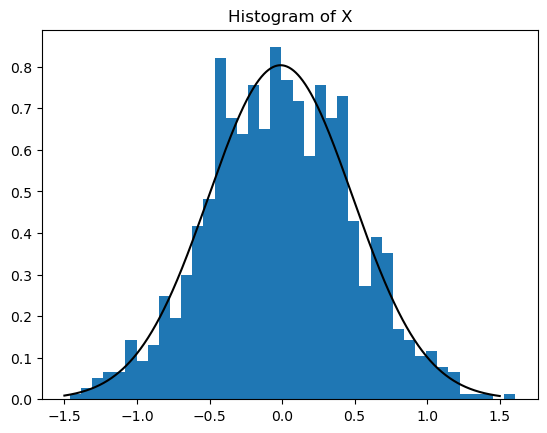

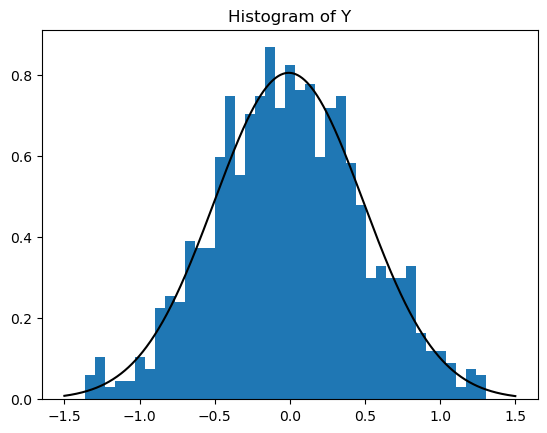

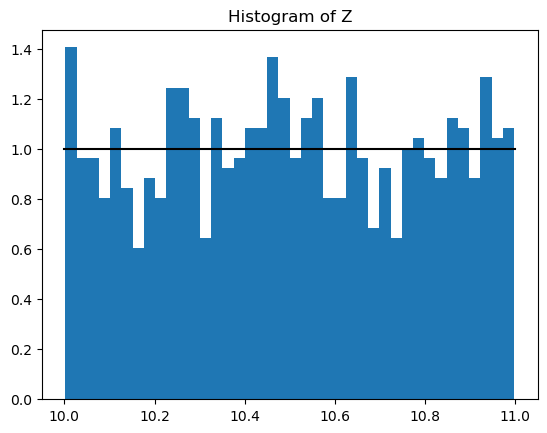

In [722]:
def f(x, mean, std):
    return (1/(std*math.sqrt(2*math.pi))) * np.exp((-(x-mean)**2)/(2*std**2))
def a(x):
    return np.full_like(x, 1/(11-10))
def norm_hist(X, title):
    plt.figure()
    mean = np.mean(X)
    std = np.std(X)
    x_values = np.linspace(-1.5, 1.5, 1000)
    y_values = f(x_values, mean, std)
    plt.plot(x_values, y_values, color="black")
    plt.hist(X, bins = 40, density = True)
    plt.title(f"Histogram of {title}")
    plt.show()
    
def simple_hist(X, title):
    plt.figure()
    x_values = np.linspace(10, 11, 1000)
    y_values = a(x_values)
    plt.plot(x_values, y_values, color="black")
    plt.hist(X, bins = 40, density = True)
    plt.title(f"Histogram of {title}")
    plt.show()

norm_hist(X, "X")
norm_hist(Y, "Y")
simple_hist(Z, "Z")

I would choose the blood from distribution Y because it is more similar to the distribution of X, which is the safe blood

In [723]:
def calculate_KL(X, Y, bound1, bound2):
    data_p = np.array(X)
    data_q = np.array(Y)
    
    # Compute standard deviations
    X_std = np.std(data_p)
    Y_std = np.std(data_q)
    eps = 1e-12

    def normal_PDF(x, mean, std):
        return (1.0/(std*math.sqrt(2*math.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)

    def pdf(x, data, std):
        # Simple KDE with Gaussian kernels
        kde_sum = 0.0
        for val in data:
            kde_sum += normal_PDF(x, val, std)
        return kde_sum / len(data)

    def P_pdf(x):
        return pdf(x, data_p, X_std)

    def Q_pdf(x):
        return pdf(x, data_q, Y_std)

    def KL_integrand(x):
        p_val = P_pdf(x)
        q_val = Q_pdf(x)
        return p_val * np.log( (p_val + eps) / (q_val + eps))

    # Numerically integrate from bound1 to bound2
    kl_value, err = quad(KL_integrand, bound1, bound2)
    return kl_value

int_kl_XY = calculate_KL(X, Y, -2.463, 2.607)
print("using integration, the KL divergence value between X and Y is:", int_kl_XY)

int_kl_XZ = calculate_KL(X, Z, -2.463, 11.997)
print("using integration, the KL divergence value between X and Z is:", int_kl_XZ)

using integration, the KL divergence value between X and Y is: 2.1269654581822315e-06
using integration, the KL divergence value between X and Z is: 26.562301227841946


In [724]:
def sample_KL(X, Y):
    data_p = np.array(X)
    data_q = np.array(Y)
    
    # Compute standard deviations
    X_std = np.std(data_p)
    Y_std = np.std(data_q)
    eps = 1e-12

    def normal_PDF(x, mean, std):
        return (1.0/(std*math.sqrt(2*math.pi))) * np.exp(-0.5 * ((x - mean)/std)**2)

    def pdf(x, data, std):
        # Simple KDE with Gaussian kernels
        kde_sum = 0.0
        for val in data:
            kde_sum += normal_PDF(x, val, std)
        return kde_sum / len(data)

    def P_pdf(x):
        return pdf(x, data_p, X_std)

    def Q_pdf(x):
        return pdf(x, data_q, Y_std)
    
    def KL_sampling(x):
        eps = 1e-12
        p_val = P_pdf(x)
        q_val = Q_pdf(x)
        return np.log( (p_val + eps) / (q_val + eps))
    
    kl_sampling = np.mean(KL_sampling(X))
    return kl_sampling

sample_KL_XY = sample_KL(X, Y)
print(sample_KL_XY)
sample_KL_XZ = sample_KL(X, Z)
print(sample_KL_XZ)

-0.0010189342317625525
26.81496169705795


In [725]:
# Using MMD to classify


def MMD_embedding(X, Y):
    gamma = 0.1
    KX = rbf_kernel(X, gamma=gamma)
    KY = rbf_kernel(Y, gamma=gamma)
    KXY= rbf_kernel(X, Y, gamma=gamma)
    MMD = np.average(KX) + np.average(KY) - 2*np.average(KXY)
    return MMD

MMD_embedding(X, Y)
MMD_embedding(X, Z)

1.9376555710163514

In [726]:
# Comparing sampling and integration
print("Integration results:")
print("\tIntegral KL(X,Y): ", int_kl_XY)
print("\tIntegral KL(X,Z): ", int_kl_XZ)
print("Sample results:")
print("\tSample KL(X,Y):   ", sample_KL_XY)
print("\tSample KL(X,Z):   ", sample_KL_XZ)
print("MMD results:")
print("\tMMD(X,Y):   ", MMD_embedding(X, Y))
print("\tMMD(X,Z):   ", MMD_embedding(X, Z))

Integration results:
	Integral KL(X,Y):  2.1269654581822315e-06
	Integral KL(X,Z):  26.562301227841946
Sample results:
	Sample KL(X,Y):    -0.0010189342317625525
	Sample KL(X,Z):    26.81496169705795
MMD results:
	MMD(X,Y):    2.1777072811701714e-06
	MMD(X,Z):    1.9376555710163514


A reasonable E threshold is halfway between the KL value for Y and Z

In [727]:
def automatic_eval(X, Q, midpoint):
    lower_bound = (min(np.min(X), np.min(Q)) - 1.0)
    upper_bound = (max(np.max(X), np.max(Q)) + 1.0)
    distance1 = calculate_KL(X,Q, lower_bound, upper_bound)
    distance2 = sample_KL(X,Q)
    if distance1 > midpoint and distance2 > midpoint:
        print(f"Reject sample, distance is {distance1} and midpoint is {midpoint}, over threshold by {distance1-midpoint}")
    else:
        print(f"Accept sample, distance is {distance1} and midpoint is {midpoint}")
        
midpoint = (sample_KL_XY + sample_KL_XZ) / 2
automatic_eval(X, Q, midpoint)

Reject sample, distance is 26.562301227841957 and midpoint is 13.406971381413094, over threshold by 13.155329846428863


Calculate the entropy of X, Y, Z, Q given population_Q.csv
– Use the numpy automatic integration and then double-check your integral results again with the
sampling method.
– Note that Uniform distribution is a poor approximation that might yield a negative entropy. Use
KDE to get a better result.
• According to Grace’s theory of Entropy, which population does Q belong to? Was Grace’s theory
correct? Should Grace get a raise?

In [728]:
def sample_entropy(x):
    x = x.flatten()
    N = x.shape[0]
    entropy = 0
    p_x = gaussian_kde(x)
    for i in range(N):
        p = p_x(x[i])[0] 
        entropy -= math.log2(p)
    return entropy/N

def integral_entropy(x, a, b):
    x = x.flatten()
    p_x = gaussian_kde(x)
    def integrand(t):
        pdf_val = p_x(t)[0]
        return -math.log2(pdf_val)*pdf_val
    entropy_value, err = quad(integrand, a, b)
    return entropy_value
    

print("Sample Entropy:")
print("\tEntropy of X: ", sample_entropy(X))
print("\tEntropy of Y: ", sample_entropy(Y))
print("\tEntropy of Z: ", sample_entropy(Z))
print("\tEntropy of Q: ", sample_entropy(Q))
print("Integral Entropy:")
print("\tEntropy of X: ", integral_entropy(X, np.min(X), np.max(X)))
print("\tEntropy of Y: ", integral_entropy(Y, np.min(Y), np.max(Y)))
print("\tEntropy of Z: ", integral_entropy(Z, np.min(Z), np.max(Z)))
print("\tEntropy of Q: ", integral_entropy(Q, np.min(Q), np.max(Q)))

Sample Entropy:
	Entropy of X:  1.0307996072276597
	Entropy of Y:  1.0251926040927362
	Entropy of Z:  0.1041812788480608
	Entropy of Q:  0.10772668220857405
Integral Entropy:
	Entropy of X:  1.063414905021008
	Entropy of Y:  1.032255613971075
	Entropy of Z:  0.07077201369142845
	Entropy of Q:  0.07013361156933845


## Question 3:

(60 points) In 2023, the CDC predicted that over 43,000 people would die from breast cancer. Prof.
Wu’s Aunt also died at a young age from breast cancer. For this problem, load the breast cancer dataset from
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html
This is one of the most famous datasets in machine learning. It is so famous, that it is built directly into Sklearn.
The researchers collected various information on the breast tissues of a female population and used it to predict if
a woman has breast cancer or not. Because of this research, it drastically reduced the necessary time and cost to
detect breast cancer. If this research existed earlier, many lives could have been saved.
In this problem, you are going to pretend that you were the original researcher in charge of this project, looking at
the data for the first time, and performing various classification algorithms on the data. You will ultimately make
the same discovery as the original researcher.
• Break the data into Train/Test/Validation.
• Use preprocessing.
• Report your accuracy using the Test dataset.
Perform the following tasks.
1) Write your own KNN algorithm to classify this problem. What’s your predictor’s accuracy on the training
data?
2) Write your own logistic regression algorithm with your own gradient descent algorithm to classify this
problem. What’s your predictor’s accuracy on the training data?
3) Write your own SVM algorithm with your own gradient descent algorithm to classify this problem. What’s
your predictor’s accuracy on the training data?
4) From the validation results, which Algorithm Performed the best and should be used?

In [729]:
# Loading
A = datasets.load_breast_cancer(return_X_y=True)
y = A[1]
X = A[0]
y = y.reshape(-1, 1)
print(X.shape)
print(y.shape)

(569, 30)
(569, 1)


In [730]:


def preprocess(x,y):
    # 1: Scale and Center the data
    scaler = pre.StandardScaler().fit(x)
    x = scaler.transform(x)
    print("x-std: ", x.std())
    print("x-mean: ", x.mean())
    # 2: Split into train (80%) and remaining (20%)
    x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=22)

    # 3: Split remaining into val (10%) and test (10%)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=22)
    y_test = y_test.reshape(-1, 1)
    y_val = y_val.reshape(-1, 1)
    y_train = y_train.reshape(-1, 1)

    print("\nX-train shape: ", x_train.shape)
    print("Y-train shape: ", y_train.shape)

    print("\nX-val shape: ", x_val.shape)
    print("Y-val shape: ", y_val.shape)

    print("\nX-test shape: ", x_test.shape)
    print("Y-test shape: ", y_test.shape)
    return x_train, y_train, x_val, y_val, x_test, y_test
x_train, y_train, x_val, y_val, x_test, y_test = preprocess(X, y)

x-std:  1.0
x-mean:  -6.118909323768877e-16

X-train shape:  (455, 30)
Y-train shape:  (455, 1)

X-val shape:  (57, 30)
Y-val shape:  (57, 1)

X-test shape:  (57, 30)
Y-test shape:  (57, 1)


In [731]:
# KNN
def KNN(X, y, K, p):
    
    norms = {}
    for i in range(X.shape[0]):
        norm = np.linalg.norm(X[i,:] - p)
        norms[i] = norm
    
    top_k = sorted(norms, key=norms.get, reverse=False)[:K]
    y_indices = [k for k in top_k]
    nn_classes = [y[i] for i in y_indices]
    
    num_class1 = np.sum(nn_classes)
    num_class0 = len(nn_classes) - num_class1
    
    if num_class0 > num_class1:
        lbl = 0
    else:
        lbl = 1
    return lbl
def test_KNN(x_train, y_train, x_test, y_test, K):
    lbls = []
    for i in range(x_test.shape[0]):
        lbl = KNN(x_train, y_train, K, x_test[i,:])
        lbls.append(lbl)
    lbls = np.array(lbls)
    correct = 0
    for i in range(x_test.shape[0]):
        
        if lbls[i] == y_test[i]:
            correct += 1
        else:
            pass
    return correct/x_test.shape[0]*100
knn_accuracy = test_KNN(x_train, y_train, x_test, y_test, 11)
print("KNN accuracy: ", knn_accuracy)

KNN accuracy:  98.24561403508771


In [732]:
# Logistic Regression
def logistic_regression(x, y, u, iter):
    def gradient(phi, x, y):
        return (1/x.shape[0]) * (phi.T @ (np.std(x)-y))
    phi = np.hstack((x, np.ones((x.shape[0], 1))))
    w = np.random.randn(x.shape[1]+1,1)
    for i in range(iter):
        grad = gradient(phi, x, y)
        w = w - u * grad
    return w

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def test_logistic_regression(x_train, y_train, x_test, y_test):
    log_weights = logistic_regression(x_train, y_train, 0.001, 20000)
    phi = np.hstack((x_test, np.ones((x_test.shape[0], 1))))
    def q(x=None, X=None, w=None):
        if X is None:
            return 1/(1 + np.exp(-x.T.dot(w)))
        else:
            return 1/(1 + np.exp(-X.dot(w)))
    pred = []
    for x in phi:
        pred.append(np.round(q(x, None, log_weights))[0])
    lbls = np.array(pred)
    correct = 0
    for i in range(x_test.shape[0]):
        
        if lbls[i] == y_test[i]:
            correct += 1
        else:
            pass
    return correct/x_test.shape[0]*100

log_regression_accuracy = test_logistic_regression(x_train, y_train, x_test, y_test)
log_regression_train_accuracy = test_logistic_regression(x_train, y_train, x_train, y_train)
print("Logistic Regression Test accuracy: ", log_regression_accuracy)
print("Logistic Regression Train accuracy: ", log_regression_train_accuracy)

Logistic Regression Test accuracy:  96.49122807017544
Logistic Regression Train accuracy:  92.52747252747253


In [742]:
def SVM_train(X, y, u, iter):
    svm_y_train = np.where(y==0, -1, 1)
    alpha = u
    w = np.random.randn(X.shape[1],1)
    
    def dw(X, y, w):
        return 2*w - X.T.dot(y)
    
    def GD(X, y ,w):
        for i in range(10000):
            w = w - alpha * dw(X, y, w)
        return w
    
    svm_w = GD(X, svm_y_train.reshape(-1, 1), w)
    return svm_w

def SVM_predict(X, y, w):
    svm_w = w
    x_test = X
    svm_y_test = np.where(y==0, -1, 1)
    
    def proj(x_test, svm_w):
        w_norm = np.linalg.norm(svm_w)
        return (x_test @ svm_w)/w_norm
    
    projections = proj(x_test, svm_w)
    
    # Indices of negative samples
    neg_id = np.where(svm_y_test.ravel() == -1)[0]
    # Indices of positive samples
    pos_id = np.where(svm_y_test.ravel() == 1)[0]
    
    neg_side = np.max(projections[neg_id])
    pos_side = np.min(projections[pos_id])
    
    b = (pos_side + neg_side) / 2
    
    pred = np.sign(x_test @ svm_w - b)
    accuracy = accuracy_score(svm_y_test, pred)
    return pred, accuracy
svm_w = SVM_train(x_train, y_train, 0.001, 500000)
pred, accuracy = SVM_predict(x_test, y_test, svm_w)
print("SVM train accuracy (percent): ", accuracy*100)

SVM train accuracy (percent):  98.24561403508771


In [734]:


# Using Kernel SVM to classify 4's and 7's
def Kernel_SVM_train(X,y):
    y = np.where(y == 0, -1, 1)
    g = 0.01
    u1 = 0.01
    K = polynomial_kernel(X, degree = 3, gamma = g)
    Y = np.diagflat(y)
    L = np.random.randn(X.shape[0],1)
    alpha = 0.001

    for i in range(1000):
        dL = np.zeros((X.shape[0], 1))
        dL[L < 0] = -1
        grad = Y @ K @ Y @ L + 2 * u1 * (L.T @ y) * y - np.ones((X.shape[0], 1)) + np.ones((X.shape[0], 1)).T @ dL
        L = L - alpha * grad
        if i % 100 == 0:
            print(f"Iteration {i}")
    y_hat = K @ (L * y)
    # Indices of negative samples
    neg_id = np.where(y.ravel() == -1)[0]
    # Indices of positive samples
    pos_id = np.where(y.ravel() == 1)[0]
    
    neg_side = np.max(y_hat[neg_id])
    pos_side = np.min(y_hat[pos_id])
    b = (pos_side + neg_side) / 2
    y_hat = np.sign(K @ (L * y) + b)
    
    accuracy = accuracy_score(y, y_hat)
    return accuracy


k_svm_accuracy = Kernel_SVM_train(x_train, y_train)
print(k_svm_accuracy)

Iteration 0
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
0.9472527472527472


In [735]:
knn_val_accuracy = test_KNN(x_train, y_train, x_val, y_val, 11)
log_val_accuracy = test_logistic_regression(x_train, y_train, x_val, y_val)
_,svm_val_accuracy = SVM_predict(x_val, y_val, svm_w)

print("KNN accuracy on validation set: ", knn_val_accuracy)
print("Logistic regression accuracy on validation set: ", log_val_accuracy)
print("SVM accuracy on validation set: ", svm_val_accuracy*100)

KNN accuracy on validation set:  96.49122807017544
Logistic regression accuracy on validation set:  94.73684210526315
SVM accuracy on validation set:  96.49122807017544


## Question 3

In [736]:
X = np.genfromtxt('2024_Fall_exam1.csv', delimiter=',')
X = X.reshape(-1,1)
print(X.shape)

(144, 1)


<function matplotlib.pyplot.show(close=None, block=None)>

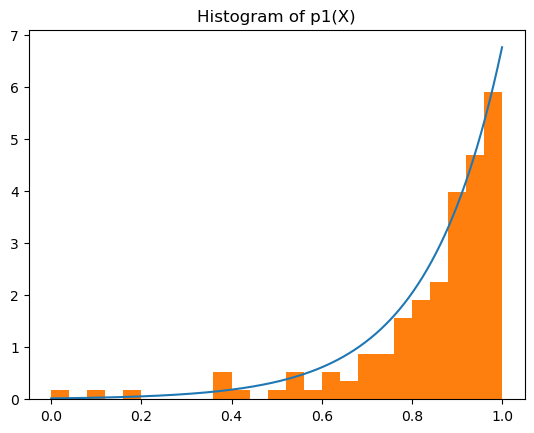

In [737]:
# Identifying distribution by hand
# Theta: Has two purposes
#       1: - or + theta in the exponent will flip the direction of the function
#       2: Value of theta will determine the rate of change
# Alpha: Shifts the whole distribution function to the left or right on X axis
theta = 6
alpha = 0.98

# Exponential function
def exp(x, theta, alpha):
    return theta * np.exp(theta*(x-alpha))

X_coords = np.linspace(0,1,1000)
Y_coords = exp(X_coords, theta, alpha)

plt.plot(X_coords, Y_coords)
plt.hist(X, bins = 25, density=True)
plt.title("Histogram of p1(X)")
plt.show

In [738]:
def log_likelihood(x, theta, alpha):
    sum = 0
    for i in range(x.shape[0]):
        term = np.log(exp(x[i], theta, alpha))
        sum += term
    return sum

def negative_grad_log_likelihood(x, theta, alpha):
    return np.sum(-1/theta - (x - alpha))

def GD(X, alpha, iterations, u):
    theta = np.random.randn(1,1) + 2
    for i in range(iterations):
        grad = negative_grad_log_likelihood(X, theta, alpha) + 1e-13
        theta = theta - u*grad
        if i%1000 == 0:
            print(f'Iteration {i}, Gradient is: {grad}')
    return theta

O = GD(X, 1, 10000, 0.001)
print(O)

Iteration 0, Gradient is: -14.283510368528399
Iteration 1000, Gradient is: -0.20677870331917295
Iteration 2000, Gradient is: -0.00707091089262871
Iteration 3000, Gradient is: -0.00024605161840388415
Iteration 4000, Gradient is: -8.567179995564453e-06
Iteration 5000, Gradient is: -2.9830369766337956e-07
Iteration 6000, Gradient is: -1.0386737612230692e-08
Iteration 7000, Gradient is: -3.616715016446255e-10
Iteration 8000, Gradient is: -1.259873095566254e-11
Iteration 9000, Gradient is: -4.4356519285647666e-13
[[6.55439235]]


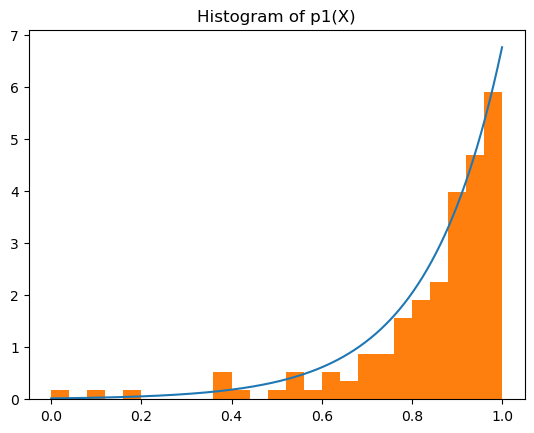

<function matplotlib.pyplot.show(close=None, block=None)>

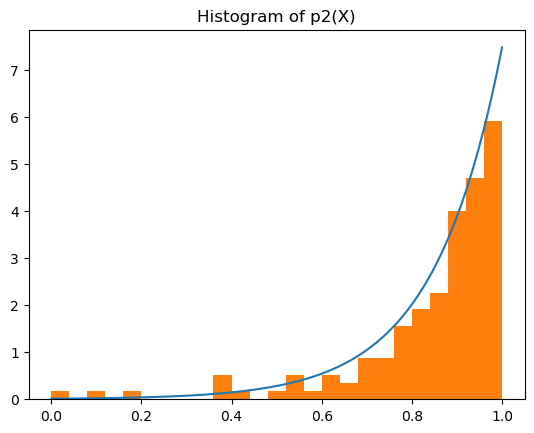

In [739]:
plt.figure()
plt.plot(X_coords, Y_coords)
plt.hist(X, bins = 25, density=True)
plt.title("Histogram of p1(X)")
plt.show()

plt.figure()
X_coords_1 = np.linspace(0,1,1000)
Y_coords_1 = exp(X_coords_1, O, alpha)
Y_coords_1 = Y_coords_1.reshape(-1,1)
plt.plot(X_coords_1, Y_coords_1)
plt.hist(X, bins = 25, density=True)
plt.title("Histogram of p2(X)")
plt.show

In [740]:
# Question 4: What percent of students will get above an 88 on the exam?
theta = O
alpha = 1
result, error = quad(exp, 0.88, 1, args=(theta, alpha))
print(f'{result*100}% of the students will get an A, using scipy.quad')

54.4576299015895% of the students will get an A, using scipy.quad


In [741]:
samples = np.random.uniform(0.88, 1, 100000)
result_samples = (1-0.88) * (1/100000) * np.sum(exp(samples, O, alpha))
print(f'{result_samples*100}% of the students will get an A, using sampling')

54.42955401884729% of the students will get an A, using sampling
